#### **This Notebook Evaluates the Optimum Cleaning, Model and PageRank Filtering Parameters along with Forward Feature Selection.**

The parameters were tuned using Optuna to maximise **F1-Score**.

Import Libraries

In [2]:
import sys
sys.path.append('..')  # Adds the parent directory to the path so Python can find the `Cleaning_and_Evaluation` package
from Cleaning_and_Evaluation import *
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold, cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

Read the spectral data

You will need to run [PageRank_Filter_Before_Clean.ipynb](../Outlier_Detection/PageRank_Filter_Before_Clean.ipynb) if you haven't already to create this file.

In [3]:
df = pd.read_csv("../data/400-1800_with_raw_scaled_surface_pagerank.csv")
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.610024
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.610024
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.610024
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.610024
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.610024
...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1.201164
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1.201164
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1.201164
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1.201164


>##### **Select the parameters found by Optuna then clean the spectra**

The spectra before cleaning.

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

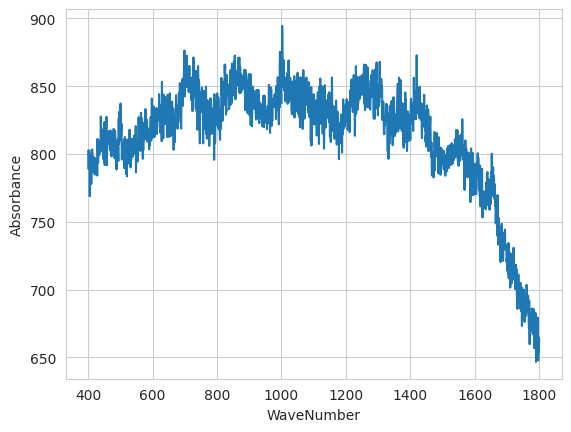

In [4]:
sample = df[df['SpecID'] == "201210-2-08"]
sns.set_style('whitegrid')
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

In [5]:
# Optuna PageRank Parameters
pagerank_cutoff = 0.974295111197113

cleaning_params = {
    'despike': False,
    'baseline_correct': True,
    'smoothing': False,
    'scaling': 'snv',
    'lam': 10**10,
    'p': 0.081,
}

# Model Parameters
model = RandomForestClassifier(random_state=1234, criterion='entropy', max_depth=None, n_estimators=60)

spectra_cleaning(df, **cleaning_params)

df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank
0,201210-1-00,293,400.22778,-0.607078,201210-1,Normal,0.610024
1,201210-1-00,294,400.91116,-0.379813,201210-1,Normal,0.610024
2,201210-1-00,295,401.59454,-0.515909,201210-1,Normal,0.610024
3,201210-1-00,296,402.27789,-0.819588,201210-1,Normal,0.610024
4,201210-1-00,297,402.96127,-0.755350,201210-1,Normal,0.610024
...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,-2.261378,210526-3,Hyperglycemia,1.201164
6239201,210526-3-09,2338,1797.72200,-2.052961,210526-3,Hyperglycemia,1.201164
6239202,210526-3-09,2339,1798.40550,-2.043384,210526-3,Hyperglycemia,1.201164
6239203,210526-3-09,2340,1799.08890,-1.926663,210526-3,Hyperglycemia,1.201164


The spectra after cleaning.

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

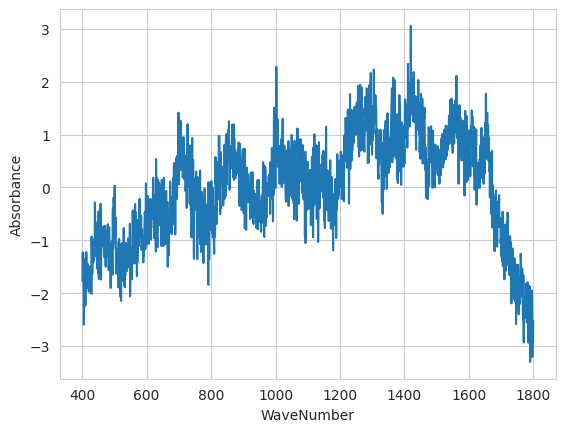

In [6]:
sample = df[df['SpecID'] == "201210-2-08"]
sns.set_style('whitegrid')
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

---

>##### **Filter the Spectra by Surface PageRank**

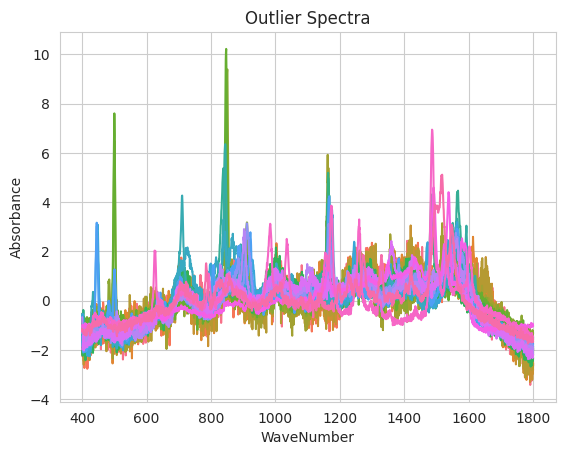

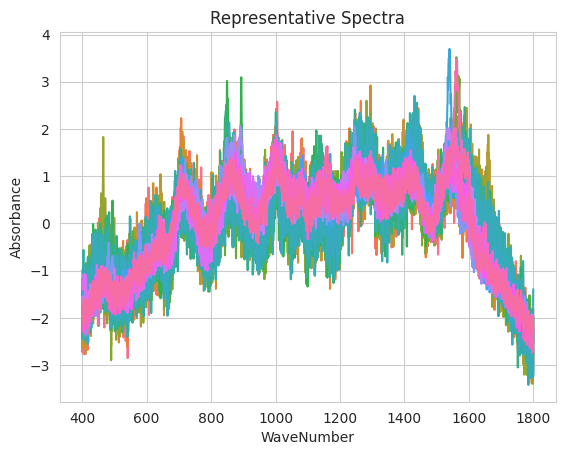

In [7]:
surface = df[df['SurID'] == "201210-2"]
remaining_spectra = surface[surface['PageRank'] > pagerank_cutoff]
outlier_spectra = surface[surface['PageRank'] < pagerank_cutoff]

sns.lineplot(x="WaveNumber", y="Absorbance", data=outlier_spectra, hue='SpecID', legend=False)
plt.title('Outlier Spectra')
plt.show()

plt.title('Representative Spectra')
sns.lineplot(x="WaveNumber", y="Absorbance", data=remaining_spectra, hue='SpecID', legend=False)
plt.show()

In [8]:
df = df[df['PageRank'] > pagerank_cutoff]

---

>##### **Dataset Description**

In [9]:
print(f"Number of remaining samples: {len(df.groupby('SpecID'))}")

Number of remaining samples: 1564


In [10]:
print("Number of Samples by Status")
df.groupby('Status')['SpecID'].nunique()

Number of Samples by Status


Status
Hyperglycemia    438
Hypoglycemia     571
Normal           555
Name: SpecID, dtype: int64

In [11]:
print("Number of Surfaces by Status")
df.groupby('Status')['SurID'].nunique()

Number of Surfaces by Status


Status
Hyperglycemia    19
Hypoglycemia     22
Normal           22
Name: SurID, dtype: int64

---

>##### **Evaluate the Model**

In [12]:
def evaluate_model(df, model):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    # Cross Validate
    scores = cross_validate(model, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [13]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

evaluate_model(wavelength_df, model)

RandomForestClassifier Cross-Validation Accuracy: 0.6643 +/- 0.0509
RandomForestClassifier Cross-Validation Precision: 0.6673 +/- 0.0525
RandomForestClassifier Cross-Validation Recall: 0.6727 +/- 0.0610
RandomForestClassifier Cross-Validation F1-Score: 0.6401 +/- 0.0404


/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

>##### **Evaluate the Model by Class**

In [14]:
def evaluate_model_by_class(df, model):
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Get unique class names
    class_names = y.unique()
    
    cv = GroupKFold(n_splits=10)

    # Lists to store the metrics by class
    accuracies = []
    precisions = [[] for _ in class_names]
    recalls = [[] for _ in class_names]
    f1_scores = [[] for _ in class_names]

    # Iterate over the splits
    for train_idx, test_idx in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, zero_division=0, labels=class_names)
        for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
            precisions[i].append(p)
            recalls[i].append(r)
            f1_scores[i].append(f)

    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {np.mean(accuracies):.4f} +/- {np.std(accuracies):.4f}\n")
    for i, class_name in enumerate(class_names):
        print(f"{class_name} Precision: {np.mean(precisions[i]):.4f} +/- {np.std(precisions[i]):.4f}")
        print(f"{class_name} Recall: {np.mean(recalls[i]):.4f} +/- {np.std(recalls[i]):.4f}")
        print(f"{class_name} F1-Score: {np.mean(f1_scores[i]):.4f} +/- {np.std(f1_scores[i]):.4f}\n")

In [15]:
evaluate_model_by_class(wavelength_df, model)

RandomForestClassifier Cross-Validation Accuracy: 0.6643 +/- 0.0509

Normal Precision: 0.7119 +/- 0.2090
Normal Recall: 0.6041 +/- 0.2175
Normal F1-Score: 0.6230 +/- 0.1658

Hyperglycemia Precision: 0.5929 +/- 0.2408
Hyperglycemia Recall: 0.6161 +/- 0.2786
Hyperglycemia F1-Score: 0.5773 +/- 0.2152

Hypoglycemia Precision: 0.6971 +/- 0.1780
Hypoglycemia Recall: 0.7979 +/- 0.1347
Hypoglycemia F1-Score: 0.7199 +/- 0.1058



---

>##### **Use Spectra Predictions to Predict the Surface**

A Surface is classified as the most predicted status of its samples.

In [16]:
def evaluate_and_predict_surface_status(df, model):
    
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # DataFrame to store the actual and predicted status for each spectrum
    predictions_df = pd.DataFrame(columns=['SurID', 'ActualStatus', 'PredictedStatus'])

    # Iterating over each fold
    for train_index, test_index in cv.split(X, y, groups=groups):
        # Splitting the dataset into the current train and test set
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_test = groups.iloc[test_index]
        
        # Fitting the model on the training set
        model.fit(X_train, y_train)

        # Predicting the status for the test set
        y_pred = model.predict(X_test)

        # Appending the SurID, actual, and predicted status to the predictions DataFrame
        fold_predictions = pd.DataFrame({
            'SurID': groups_test.values,
            'ActualStatus': y_test.values,
            'PredictedStatus': y_pred
        })

        predictions_df = pd.concat([predictions_df, fold_predictions], ignore_index=True)

    # Return the most common prediction of each spectra within the surface
    return predictions_df.groupby('SurID').agg(lambda x: x.mode()[0]).reset_index()

In [17]:
surface_predictions = evaluate_and_predict_surface_status(wavelength_df, model)
surface_predictions

,SurID,ActualStatus,PredictedStatus
0,201210-1,Normal,Normal
1,201210-2,Normal,Hypoglycemia
2,210114-1,Normal,Normal
3,210114-2,Normal,Normal
4,210120-1,Hyperglycemia,Normal
...,...,...,...
58,210519-3,Hyperglycemia,Hyperglycemia
59,210524-1,Hypoglycemia,Hyperglycemia
60,210526-1,Hyperglycemia,Hyperglycemia
61,210526-2,Hyperglycemia,Normal


In [18]:
print(classification_report(surface_predictions['ActualStatus'], surface_predictions['PredictedStatus'], digits=4))

               precision    recall  f1-score   support

Hyperglycemia     0.6500    0.6842    0.6667        19
 Hypoglycemia     0.6429    0.8182    0.7200        22
       Normal     0.8000    0.5455    0.6486        22

     accuracy                         0.6825        63
    macro avg     0.6976    0.6826    0.6784        63
 weighted avg     0.6999    0.6825    0.6790        63

